In [ ]:
pip install tensorflow matplotlib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path to the unzipped dataset folder
dataset_path = '/content/drive/MyDrive/NSLDataset/'

# Example: listing subfolders or files
import os

classes = os.listdir(dataset_path)
print("Classes found:", classes)


Classes found: ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '4', '5', '6', '7', '8', '9']


In [ ]:
import os
import shutil
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf


# ------------------- Step 1: Define Paths -------------------
original_dataset_dir = '/content/drive/MyDrive/NSLDataset'  # This is your unzipped dataset
base_dir = '/content/drive/MyDrive/Dataset'  # Folder to save the split data

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# ------------------- Step 2: Create Directory Structure -------------------
for folder in [train_dir, val_dir, test_dir]:
    os.makedirs(folder, exist_ok=True)

# ------------------- Step 3: Split Each Class -------------------
# Assuming class-wise folders are inside original_dataset_dir
classes = os.listdir(original_dataset_dir)

for class_name in classes:
    class_path = os.path.join(original_dataset_dir, class_name)
    if not os.path.isdir(class_path):
        continue  # skip any non-directory file

    images = os.listdir(class_path)
    images = [img for img in images if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # Shuffle and split into 70% train, 10% val, 20% test
    train_imgs, temp_imgs = train_test_split(images, test_size=0.30, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=2/3, random_state=42)

    # Create class directories
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Copy files
    for img in train_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))
    for img in val_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(val_dir, class_name, img))
    for img in test_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, class_name, img))

print("Dataset split into Train (70%), Val (10%), Test (20%)")



✅ Dataset split into Train (70%), Val (10%), Test (20%)
Found 25200 images belonging to 36 classes.
Found 3600 images belonging to 36 classes.
Found 7200 images belonging to 36 classes.
Class labels: ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '4', '5', '6', '7', '8', '9']


In [ ]:
# ------------------- Step 4: Prepare Data Generators -------------------
from tensorflow.keras.preprocessing.image import ImageDataGenerator
img_height = 128
img_width = 128
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

class_names = list(train_data.class_indices.keys())
print("Class labels:", class_names)


Found 25189 images belonging to 36 classes.
Found 3600 images belonging to 36 classes.
Found 7196 images belonging to 36 classes.
Class labels: ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '4', '5', '6', '7', '8', '9']


In [ ]:
from tensorflow.keras import layers, models, callbacks

# Define the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Dropout to reduce overfitting

    layers.Dense(36, activation='softmax')  # 36 classes for Nepali characters
])


In [ ]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# EarlyStopping callback
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
import os
from PIL import Image

def clean_dataset(directory):
    for root, dirs, files in os.walk(directory):
        for filename in files:
            file_path = os.path.join(root, filename)
            try:
                # Try opening the image
                with Image.open(file_path) as img:
                    img.verify()  # Verify it’s a proper image
            except Exception as e:
                print(f"❌ Removing corrupted file: {file_path}")
                os.remove(file_path)

# Use it on your dataset
clean_dataset('/content/drive/MyDrive/Dataset')


❌ Removing corrupted file: /content/drive/MyDrive/Dataset/train/35/345.jpg
❌ Removing corrupted file: /content/drive/MyDrive/Dataset/train/35/343.jpg
❌ Removing corrupted file: /content/drive/MyDrive/Dataset/train/35/349.jpg
❌ Removing corrupted file: /content/drive/MyDrive/Dataset/train/35/354.jpg
❌ Removing corrupted file: /content/drive/MyDrive/Dataset/train/35/342.jpg
❌ Removing corrupted file: /content/drive/MyDrive/Dataset/train/35/353.jpg
❌ Removing corrupted file: /content/drive/MyDrive/Dataset/train/35/35.jpg
❌ Removing corrupted file: /content/drive/MyDrive/Dataset/train/35/352.jpg
❌ Removing corrupted file: /content/drive/MyDrive/Dataset/train/35/344.jpg
❌ Removing corrupted file: /content/drive/MyDrive/Dataset/train/35/347.jpg
❌ Removing corrupted file: /content/drive/MyDrive/Dataset/train/35/341.jpg
❌ Removing corrupted file: /content/drive/MyDrive/Dataset/test/35/348.jpg
❌ Removing corrupted file: /content/drive/MyDrive/Dataset/test/35/346.jpg
❌ Removing corrupted file: /

In [ ]:
# Clean all splits
clean_dataset("/content/drive/MyDrive/Dataset/train")
clean_dataset("/content/drive/MyDrive/Dataset/val")
clean_dataset("/content/drive/MyDrive/Dataset/test")

In [ ]:
# Train the model with early stopping
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[early_stop]
)

Epoch 1/50
788/788 ━━━━━━━━━━━━━━━━━━━━ 108s 132ms/step - accuracy: 0.3823 - loss: 2.1328 - val_accuracy: 0.9286 - val_loss: 0.2209
Epoch 2/50
788/788 ━━━━━━━━━━━━━━━━━━━━ 102s 129ms/step - accuracy: 0.8144 - loss: 0.4965 - val_accuracy: 0.9533 - val_loss: 0.1355
Epoch 3/50
788/788 ━━━━━━━━━━━━━━━━━━━━ 99s 126ms/step - accuracy: 0.8656 - loss: 0.3562 - val_accuracy: 0.9642 - val_loss: 0.1051
Epoch 4/50
788/788 ━━━━━━━━━━━━━━━━━━━━ 142s 126ms/step - accuracy: 0.8986 - loss: 0.2695 - val_accuracy: 0.9667 - val_loss: 0.0895
Epoch 5/50
788/788 ━━━━━━━━━━━━━━━━━━━━ 100s 127ms/step - accuracy: 0.9105 - loss: 0.2287 - val_accuracy: 0.9761 - val_loss: 0.0691
Epoch 6/50
788/788 ━━━━━━━━━━━━━━━━━━━━ 106s 134ms/step - accuracy: 0.9211 - loss: 0.2059 - val_accuracy: 0.9700 - val_loss: 0.0782
Epoch 7/50
788/788 ━━━━━━━━━━━━━━━━━━━━ 102s 130ms/step - accuracy: 0.9363 - loss: 0.1733 - val_accuracy: 0.9817 - val_loss: 0.0576
Epoch 8/50
788/788 ━━━━━━━━━━━━━━━━━━━━ 110s 139ms/step - accuracy: 0.9433 - 

In [ ]:
# STEP 6: Save the Model
model.save('/content/drive/MyDrive/ka_to_gyan_model.h5')

In [ ]:
print(train_data.class_indices)


{'0': 0, '1': 1, '10': 2, '11': 3, '12': 4, '13': 5, '14': 6, '15': 7, '16': 8, '17': 9, '18': 10, '19': 11, '2': 12, '20': 13, '21': 14, '22': 15, '23': 16, '24': 17, '25': 18, '26': 19, '27': 20, '28': 21, '29': 22, '3': 23, '30': 24, '31': 25, '32': 26, '33': 27, '34': 28, '35': 29, '4': 30, '5': 31, '6': 32, '7': 33, '8': 34, '9': 35}


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

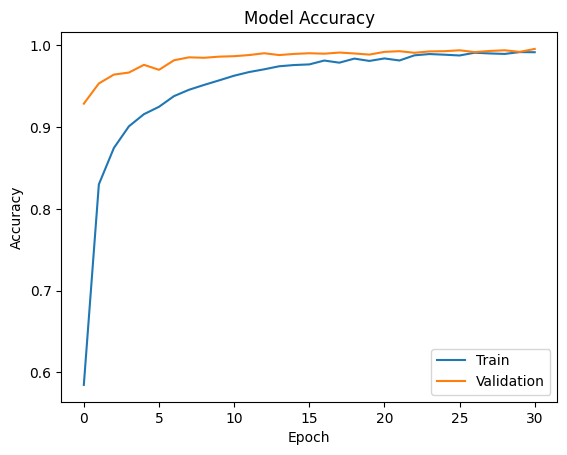

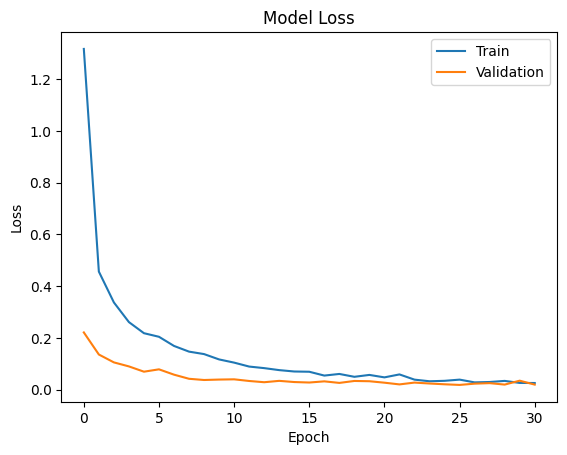

In [ ]:
# Accuracy
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


225/225 ━━━━━━━━━━━━━━━━━━━━ 26s 114ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94       200
           1       0.98      0.94      0.96       200
          10       1.00      1.00      1.00       200
          11       1.00      1.00      1.00       200
          12       1.00      1.00      1.00       200
          13       1.00      1.00      1.00       200
          14       1.00      1.00      1.00       200
          15       1.00      1.00      1.00       200
          16       1.00      0.99      0.99       200
          17       0.99      1.00      1.00       200
          18       1.00      1.00      1.00       200
          19       1.00      1.00      1.00       200
           2       0.92      0.96      0.94       200
          20       1.00      1.00      1.00       200
          21       1.00      1.00      1.00       200
          22       1.00      1.00      1.00       200
          23 

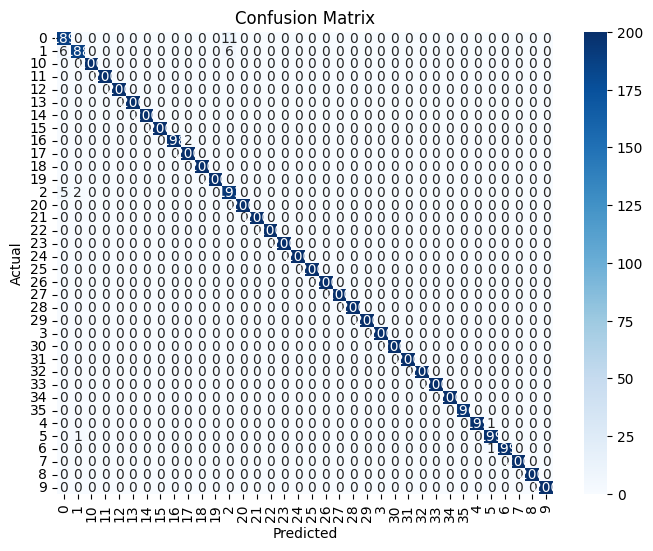

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Predictions
predictions = model.predict(test_data)
y_pred = np.argmax(predictions, axis=1)
y_true = test_data.classes

print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
